In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

In [5]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))
if len(gpu_devices) > 0:
    print("GPU(s) detected:", gpu_devices)
else:
    print("No GPU detected. TensorFlow is running on CPU.")

TensorFlow version: 2.12.0
Num GPUs Available:  0
No GPU detected. TensorFlow is running on CPU.


### READING ANIMELIST.CSV

In [6]:
import os

In [7]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [8]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True,usecols=["user_id","anime_id","rating"])

In [9]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [10]:
len(rating_df)

5000000

#### DATA PROCESSING

In [11]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [12]:
len(rating_df)

3246641

In [13]:
min_rating =min(rating_df["rating"])

In [14]:
max_rating =max(rating_df["rating"])

In [15]:
min_rating,max_rating

(0, 10)

In [16]:
avg_rating =np.mean(rating_df["rating"])

In [17]:
avg_rating

4.122732695114736

In [18]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [19]:
rating_df.duplicated().sum()

0

In [20]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [21]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
print(user2user_encoded)
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
print(user2user_decoded)

{2: 0, 6: 1, 12: 2, 16: 3, 17: 4, 19: 5, 21: 6, 41: 7, 42: 8, 44: 9, 47: 10, 53: 11, 55: 12, 60: 13, 66: 14, 73: 15, 74: 16, 85: 17, 89: 18, 90: 19, 94: 20, 98: 21, 102: 22, 108: 23, 111: 24, 112: 25, 120: 26, 121: 27, 122: 28, 135: 29, 145: 30, 146: 31, 147: 32, 153: 33, 155: 34, 156: 35, 172: 36, 174: 37, 184: 38, 190: 39, 193: 40, 194: 41, 198: 42, 204: 43, 205: 44, 209: 45, 214: 46, 219: 47, 222: 48, 227: 49, 228: 50, 235: 51, 238: 52, 240: 53, 243: 54, 248: 55, 251: 56, 252: 57, 257: 58, 264: 59, 267: 60, 272: 61, 274: 62, 275: 63, 284: 64, 285: 65, 286: 66, 290: 67, 291: 68, 293: 69, 300: 70, 301: 71, 306: 72, 308: 73, 310: 74, 313: 75, 314: 76, 316: 77, 320: 78, 321: 79, 324: 80, 325: 81, 326: 82, 327: 83, 330: 84, 336: 85, 340: 86, 345: 87, 346: 88, 349: 89, 350: 90, 366: 91, 367: 92, 371: 93, 372: 94, 375: 95, 381: 96, 382: 97, 386: 98, 389: 99, 398: 100, 405: 101, 406: 102, 413: 103, 414: 104, 418: 105, 423: 106, 426: 107, 428: 108, 431: 109, 432: 110, 436: 111, 437: 112, 438

In [22]:
n_users = len(user2user_encoded)

In [23]:
n_users

4203

In [24]:
## 11054 : 12  -> user2user encoded
## 12 : 11054 ---> usser2userdecocded

In [25]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [26]:
n_anime = len(anime2anime_encoded)

In [27]:
n_anime

17149

In [28]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [29]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [30]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [31]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [32]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

In [33]:
len(X_train)

3245641

In [34]:
len(X_test)

1000

In [35]:
type(X_train)

numpy.ndarray

In [36]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [37]:
type(X_test_array)

list

In [38]:
type(X_test_array[0])

numpy.ndarray

#### MODEL ARCHITECTURE

In [39]:
def RecommenderNet():
    embedding_size =128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [40]:
model = RecommenderNet()

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 anime (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       537984      ['user[0][0]']                   
                                                                                                  
 anime_embedding (Embedding)    (None, 1, 128)       2195072     ['anime[0][0]']                  
                                                                                              

In [42]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [45]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=5,monitor="val_loss",mode="min",restore_best_weights=True)

In [46]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [47]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 [==============================] - 37s 106ms/step - loss: 0.8020 - mae: 0.3824 - mse: 0.1978 - val_loss: 0.7369 - val_mae: 0.3691 - val_mse: 0.1752 - lr: 1.0000e-05
Epoch 2/20
325/325 [==============================] - 33s 100ms/step - loss: 0.7985 - mae: 0.3811 - mse: 0.1964 - val_loss: 0.7858 - val_mae: 0.3777 - val_mse: 0.1926 - lr: 1.8000e-05
Epoch 3/20
325/325 [==============================] - 31s 95ms/step - loss: 0.7926 - mae: 0.3789 - mse: 0.1941 - val_loss: 0.7873 - val_mae: 0.3779 - val_mse: 0.1930 - lr: 2.6000e-05
Epoch 4/20
325/325 [==============================] - 30s 93ms/step - loss: 0.7842 - mae: 0.3757 - mse: 0.1907 - val_loss: 0.7837 - val_mae: 0.3771 - val_mse: 0.1916 - lr: 3.4000e-05
Epoch 5/20
325/325 [==============================] - 28s 86ms/step - loss: 0.7728 - mae: 0.3711 - mse: 0.1861 - val_loss: 0.7772 - val_mae: 0.3752 - val_mse: 0.1891 - lr: 4.2000e-05
Epoch 6/20
325/325 [==============================] - 29s 88ms/step - loss: 0.7568 

In [48]:
model.load_weights(checkpoint_filepath)

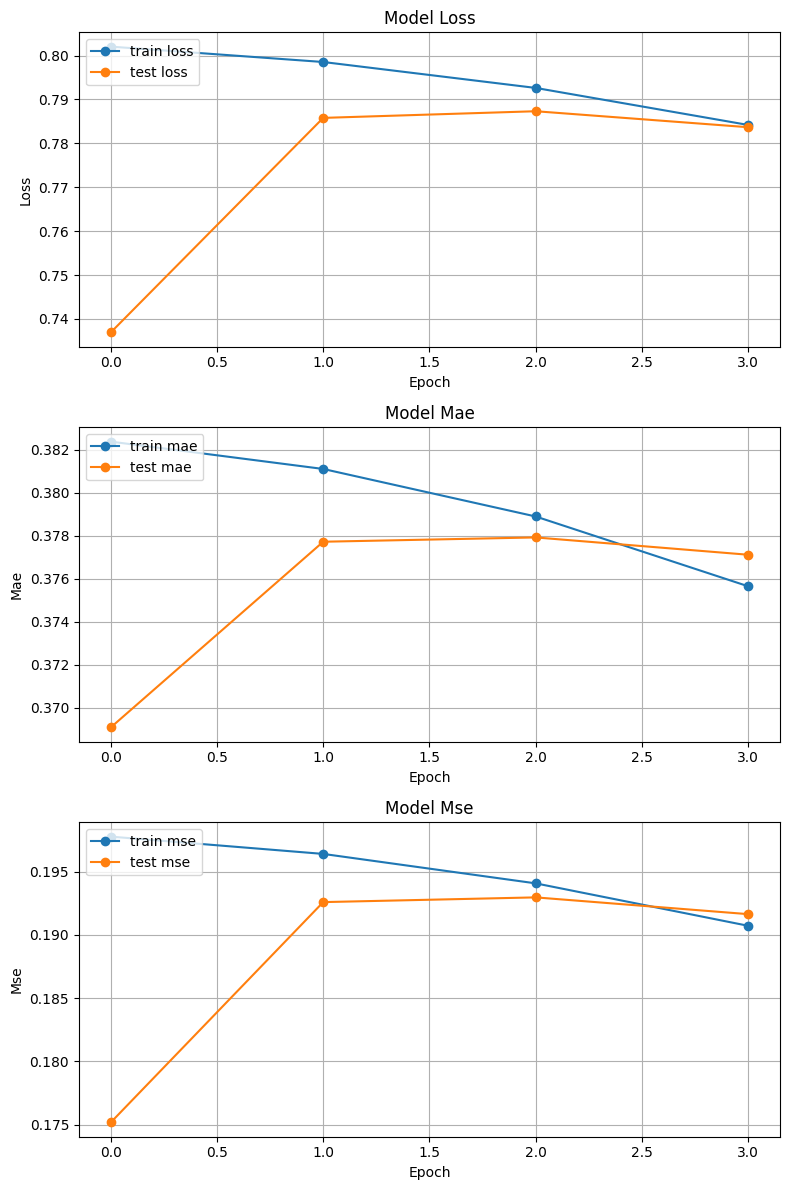

In [49]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [50]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [53]:
anime_weights = extract_weights("anime_embedding",model)
anime_weights

array([[ 0.11693772,  0.13648908, -0.10522329, ...,  0.00961834,
        -0.08362926,  0.05748362],
       [ 0.11942669, -0.04805731,  0.11713198, ..., -0.13612667,
        -0.06769575, -0.14946614],
       [-0.03558607,  0.15472628, -0.09146122, ..., -0.0975646 ,
        -0.12789336, -0.03961352],
       ...,
       [-0.03209106, -0.08699754, -0.10306925, ..., -0.09563493,
        -0.00508642, -0.02436737],
       [-0.14907043,  0.0398634 , -0.00134276, ..., -0.13647798,
        -0.10021654,  0.10526466],
       [ 0.12215987,  0.12283179,  0.09869482, ...,  0.0220389 ,
        -0.01959253, -0.09300774]], dtype=float32)

In [54]:
user_weights = extract_weights("user_embedding",model)
user_weights

array([[ 0.04299921,  0.09571452,  0.07623474, ..., -0.05485731,
         0.05388185, -0.01670073],
       [-0.01494106,  0.08564702, -0.08324568, ..., -0.13631986,
         0.08752708, -0.04673852],
       [ 0.03069106, -0.02944444, -0.13159733, ...,  0.07207824,
         0.1350365 ,  0.097385  ],
       ...,
       [ 0.00474127,  0.05252568, -0.02732594, ..., -0.11198705,
         0.13889697, -0.03560087],
       [ 0.05684311,  0.05054696,  0.11793099, ...,  0.1096227 ,
        -0.10602365, -0.13726772],
       [ 0.00598715, -0.11799392,  0.14254054, ..., -0.04997231,
        -0.07290658, -0.01647907]], dtype=float32)

#### READING ANIME.CSV

In [55]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [59]:
df = df.replace("Unknown",np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          12421 non-null  object
 3   Genres         17499 non-null  object
 4   English name   6997 non-null   object
 5   Japanese name  17514 non-null  object
 6   Type           17525 non-null  object
 7   Episodes       17046 non-null  object
 8   Aired          17253 non-null  object
 9   Premiered      4745 non-null   object
 10  Producers      9768 non-null   object
 11  Licensors      3946 non-null   object
 12  Studios        10483 non-null  object
 13  Source         13995 non-null  object
 14  Duration       17007 non-null  object
 15  Rating         16874 non-null  object
 16  Ranked         15800 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [57]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [60]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [62]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [63]:
getAnimeName(6702)

'Fairy Tail'

In [64]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [66]:
df

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,盗墓笔记之秦岭神树,ONA,NaN,"Apr 4, 2021 to ?",NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,48481,Daomu Biji Zhi Qinling Shen Shu
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,見える子ちゃん,TV,NaN,2021 to ?,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48483,Mieruko-chan
17559,48488,Higurashi no Naku Koro ni Sotsu,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,NaN,"Jul, 2021 to ?",Summer 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48488,Higurashi:When They Cry – SOTSU
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,ヤマノススメ Next Summit,TV,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48491,Yama no Susume: Next Summit


In [65]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [67]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [68]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [69]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]
    

In [70]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [71]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV 

In [72]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [73]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [74]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [75]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [76]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [77]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [78]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION

In [79]:
pd.set_option("max_colwidth",None)

In [80]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [81]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Eight Clouds Rising,0.322623,"Adventure, Supernatural, Historical, Horror, Shoujo"
8,Kaiju Decode,0.318043,NaN
7,Fuusen,0.309944,"Kids, Music"
6,Majo demo Steady,0.305103,"Comedy, Magic, Romance, Ecchi"
5,Cyborg 009,0.304651,"Action, Adventure, Mecha, Sci-Fi, Shounen"
4,5 Centimeters Per Second,0.299302,"Drama, Romance, Slice of Life"
3,Yuusha Shirei Dagwon,0.297260,"Action, Adventure, Martial Arts, Mecha, Super Power, School"
2,Hikaru no Go Recaps,0.282631,"Game, Supernatural, Shounen"
1,The Closet,0.282076,Drama
0,Belle and Sebastian,0.274944,"Adventure, Historical"


### USER BASED RECOMMENDATION

In [83]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [84]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,14041,0.306547
8,13085,0.303511
7,15684,0.290720
6,7624,0.289672
5,5762,0.289007
4,5107,0.286396
3,4828,0.278427
2,14320,0.274515
1,300,0.267305
0,2822,0.267011


In [85]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [86]:
from collections import defaultdict

In [87]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [88]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [82]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [92]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




### Penjelasan Baris Persentil

#### Kode
```python
user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
```

- **Penjelasan**: Baris ini menghitung **persentil ke-75** dari semua rating yang diberikan oleh pengguna tertentu untuk anime yang telah mereka tonton. Persentil ke-75 adalah nilai di mana 75% rating pengguna berada di bawah nilai tersebut, dan 25% rating berada di atasnya. Dengan kata lain, ini adalah batas yang memisahkan 25% rating tertinggi dari sisanya. Tujuannya adalah untuk fokus hanya pada anime yang benar-benar disukai pengguna, yaitu yang memiliki rating tinggi.

- **Analogi**: Bayangkan Anda punya daftar ulasan makanan dari teman Anda, dengan skor dari 1 sampai 10. Anda ingin tahu makanan apa saja yang termasuk dalam 25% ulasan terbaik (paling enak menurut teman Anda). Persentil ke-75 adalah skor minimum yang masuk ke dalam kelompok "sangat enak" ini. Misalnya, jika teman Anda memberikan skor [2, 4, 6, 8, 10], persentil ke-75 mungkin sekitar 8, artinya hanya makanan dengan skor 8 atau lebih yang dianggap favorit.

#### Detail Teknis
- **`np.percentile`**: Fungsi dari *library* NumPy yang menghitung nilai persentil dari sekumpulan data.
  - **Parameter**:
    - `animes_watched_by_user.rating`: Kolom `rating` dari *DataFrame* `animes_watched_by_user`, yang berisi semua rating anime dari pengguna tertentu. **Analogi**: Daftar skor ulasan makanan dari teman Anda.
    - `75`: Menunjukkan persentil ke-75, yaitu nilai di mana 75% data berada di bawahnya. **Analogi**: Batas untuk memilih 25% makanan terlezat.
  - **Output**: Angka (biasanya desimal) yang mewakili batas rating untuk 25% tertinggi. Misalnya, jika rating adalah [2, 4, 6, 8, 10], outputnya sekitar 8.
- **Konteks dalam Fungsi**: Nilai `user_rating_percentile` ini digunakan untuk memfilter anime, sehingga hanya anime dengan rating sama atau di atas nilai ini yang dianggap sebagai favorit pengguna. Ini membantu fungsi fokus pada anime yang benar-benar disukai, bukan sekadar ditonton.

#### Cara Kerja Persentil (Langkah demi Langkah)
1. **Ambil Data Rating**: Fungsi mengambil semua rating dari pengguna tertentu (dari `animes_watched_by_user.rating`). Misalnya, pengguna memberikan rating: [3, 5, 7, 8, 9, 10].
2. **Urutkan Data**: NumPy secara internal mengurutkan rating dari kecil ke besar: [3, 5, 7, 8, 9, 10].
3. **Hitung Posisi Persentil**: Persentil ke-75 berarti kita mencari nilai di posisi 75% dari daftar yang sudah diurutkan. Untuk 6 rating, posisi ini dihitung sebagai:
   - Posisi = 75/100 * (6 - 1) = 0.75 * 5 = 3.75 (di antara indeks 3 dan 4).
4. **Interpolasi**: Karena posisi 3.75 bukan bilangan bulat, NumPy menginterpolasi antara rating di indeks 3 (nilai 8) dan indeks 4 (nilai 9). Hasilnya adalah nilai sekitar 8.25 (tergantung metode interpolasi NumPy).
5. **Hasil**: `user_rating_percentile` bernilai 8.25, artinya rating 8.25 ke atas adalah 25% rating tertinggi pengguna.

#### Mengapa Persentil ke-75?
- **Tujuan**: Memilih persentil ke-75 berarti kita hanya mengambil 25% anime dengan rating tertinggi, yang dianggap sebagai anime favorit pengguna. Ini memastikan bahwa rekomendasi berfokus pada apa yang benar-benar disukai, bukan sekadar anime yang ditonton dengan rating rendah.
- **Analogi**: Jika teman Anda menilai 100 makanan, persentil ke-75 membantu Anda memilih 25 makanan yang mendapat ulasan terbaik, bukan makanan biasa-biasa saja.


#### Contoh Praktis
Misalkan `animes_watched_by_user` berisi data berikut untuk pengguna dengan `user_id=11880`:
```
user_id | anime_id | rating
11880   | 12345    | 8
11880   | 67890    | 6
11880   | 54321    | 9
11880   | 98765    | 7
```
- Rating: [8, 6, 9, 7].
- Urutkan: [6, 7, 8, 9].
- Persentil ke-75 untuk 4 data:
  - Posisi = 0.75 * (4 - 1) = 2.25 (di antara indeks 2 dan 3).
  - Interpolasi antara rating 8 (indeks 2) dan 9 (indeks 3): 8 + 0.25 * (9 - 8) = 8.25.
- Hasil: `user_rating_percentile = 8.25`.
- Anime dengan rating >= 8.25 (hanya anime dengan rating 9) akan dipilih sebagai favorit.

#### Kegunaan dalam Sistem Rekomendasi
- **Fokus pada Favorit**: Persentil ke-75 memastikan hanya anime yang benar-benar disukai pengguna yang digunakan untuk analisis, sehingga rekomendasi lebih relevan.
- **Efisiensi**: Mengurangi jumlah data yang diproses dengan hanya mempertimbangkan rating tertinggi, menghemat waktu dan sumber daya.
- **Personalisasi**: Membantu memahami selera pengguna untuk membangun rekomendasi yang sesuai.

Dengan pendekatan ini, fungsi memastikan bahwa hanya anime yang paling disukai pengguna yang menjadi dasar untuk langkah selanjutnya, seperti rekomendasi berbasis pengguna atau hibrida.

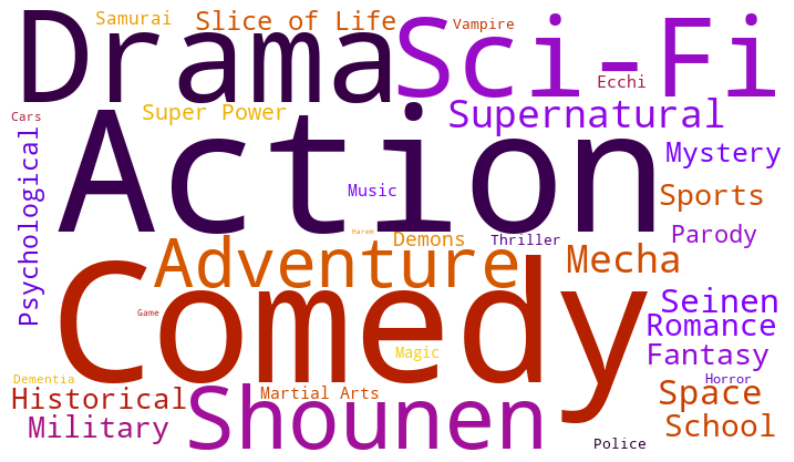

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [91]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [94]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [95]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [96]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [97]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,8,Steins;Gate,"Thriller, Sci-Fi","The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."


### HYBRID RECOMMENDER SYSTEM

In [99]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [101]:
print(hybrid_recommendation(11880))

['Steins;Gate', 'Toradora!', 'Angel Beats!', 'Death Note', 'Hyouka', 'Code Geass:Lelouch of the Rebellion', 'Sword Art Online', 'Attack on Titan', 'Code Geass:Lelouch of the Rebellion R2', 'Another']
['Gakuen Babysitters Special', 'Steins;Gate', 'Toradora!', 'Angel Beats!', 'Death Note', 'Hyouka', 'Code Geass:Lelouch of the Rebellion', 'Sword Art Online', 'Attack on Titan', 'Code Geass:Lelouch of the Rebellion R2']
